# MZI Phase shifter Heater model

Varying the phase by application of volatge

Using the circuit modelling with SAX and GDSFactory, with SiEPIC PDK

In [1]:
# Import the necassry packages
import gplugins.modes as gm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import meep as mp
import gdsfactory as gf
from ubcpdk import PDK, cells
from functools import partial
PDK.activate()
import sax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from simphony.libraries import siepic


Using MPI version 4.1, 1 processes
2025-10-28 05:08:59.132 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.31.0' installed at ['/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep']


## Loading MZI with phase shifter from GDSFactory

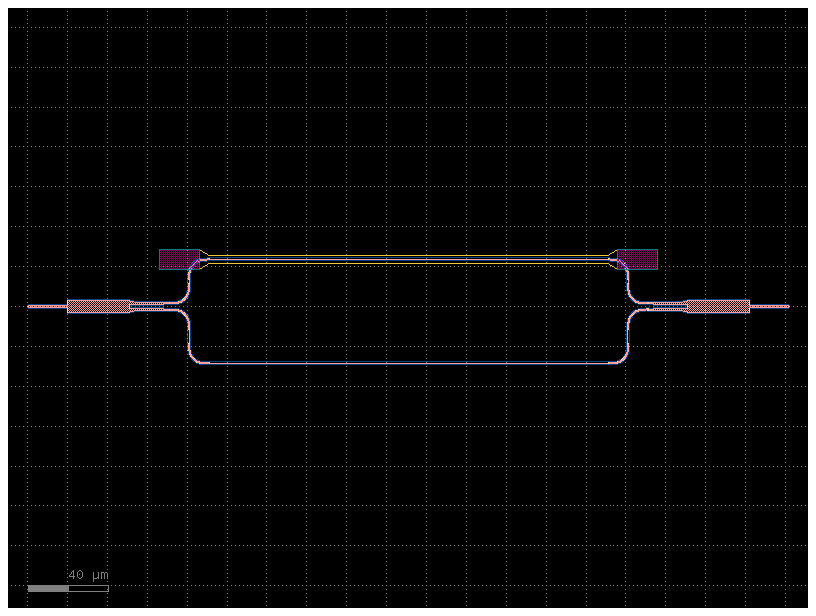

In [2]:
delta_length = 10 # Difference in length b/w top and bottom wg
mzi_component = gf.components.mzi_phase_shifter(delta_length=delta_length)
mzi_component.plot()

## Creating a phase shifter model 

loading the ybranch as the splitter and waveguide from the SiEPIC PDK


In [78]:
def phase_shifter_heater(
    wl: float = 1.55,
    neff: float = 2.34,
    voltage: float = 0,
    length: float = 10,
    loss: float = 0.0,
) -> sax.SDict:
    """Returns simple phase shifter model.

    Args:
        wl: wavelength.
        neff: effective index.
        voltage: voltage.
        length: length.
        loss: loss in dB/cm.
    """
    deltaphi = voltage * jnp.pi
    phase = 2 * jnp.pi * neff * length / wl + deltaphi
    amplitude = jnp.asarray(10 ** (-loss * length / 20), dtype=complex)
    transmission = amplitude * jnp.exp(1j * phase)
    return sax.reciprocal(
        {
            ("o1", "o2"): transmission,
            ("l_e1", "r_e1"): 0.0,
            ("l_e2", "r_e2"): 0.0,
            ("l_e3", "r_e3"): 0.0,
            ("l_e4", "r_e4"): 0.0,
        }
    )

def rename_ports(model_func, port_mapping, **kwargs): 
    """Generic wrapper to rename ports from any model beacuse SiEPIC has 
    different naming convention from gdsfactory"""
    S_dict = model_func(**kwargs)
    return {
        (port_mapping.get(p1, p1), port_mapping.get(p2, p2)): value
        for (p1, p2), value in S_dict.items()
    }

# Create the renamed model
y_branch_renamed = partial(
    rename_ports,
    model_func=siepic.y_branch,
    port_mapping={'port_1': 'o1', 'port_2': 'o2', 'port_3': 'o3'}
)

waveguide_renamed = partial (
    rename_ports,
    model_func=siepic.waveguide,
    port_mapping={'o0':'o1', 'o1':'o2'}
)

models = {
    "bend_euler": waveguide_renamed, # ignoring the bend losses (Should create own s-parameter library from MEEP)
    "straight": waveguide_renamed,
    "mmi1x2": y_branch_renamed, # using y-branch for the splitter
    "straight_heater_metal": phase_shifter_heater
}

netlist = mzi_component.get_netlist()
mzi_circuit, _ = sax.circuit(netlist=netlist, models=models)
S = mzi_circuit(wl=1.55)

## Applying voltage

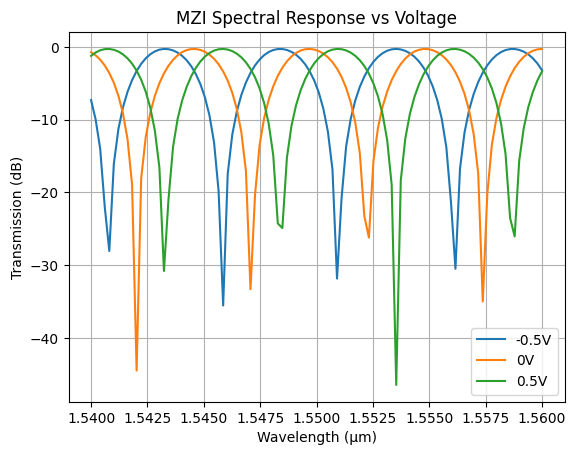

In [87]:
# Define wavelength range
wl = np.linspace(1.54, 1.56, 100)
voltages = [-0.5, 0, 0.5]
for voltage in voltages:
# Initialize arrays to store results
    S_o1_o2 = []
    for i, wavelength in enumerate(wl): # TODO: issue with jax array 
        S = mzi_circuit(wl=wavelength, sxt={"voltage":voltage})
        S_o1_o2.append(S['o1', 'o2'])

    plt.plot(wl, 10*np.log10(np.abs(S_o1_o2)**2), label=f"{voltage}V")
    plt.xlabel('Wavelength (μm)')
    plt.ylabel('Transmission (dB)')
plt.title('MZI Spectral Response vs Voltage')
plt.legend()
plt.grid(True)
plt.show()